In [15]:
import pandas as pd
import numpy as np
import os
import preprocessor 
import re
import string
import spacy
from spacy.lang.en import stop_words as spacy_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
import matplotlib.pyplot as plt
plt.style.use('default')

# Load Data

In [6]:
folder_path = "../Data Twitter/Train/"
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('txt'):
        path = os.path.join(folder_path,filename)
        df = pd.read_csv(path,sep='\t',header=None)
        df = df.drop(columns=[df.columns[0],df.columns[3]])
        dfs.append(df)

df_train = pd.concat(dfs)
df_train.columns = ['text','label']
df_train['label_numeric'] = df_train['label'].astype('category').cat.codes
print('total train samples : ',len(df_train))
print(df_train['label'].value_counts())

class_mapping = list(df_train['label'].astype('category').cat.categories)

total train samples :  3613
fear       1147
anger       857
joy         823
sadness     786
Name: label, dtype: int64


In [7]:
folder_path = "../Data Twitter/Dev/"
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('txt'):
        path = os.path.join(folder_path,filename)
        df = pd.read_csv(path,sep='\t',header=None)
        df = df.drop(columns=[df.columns[0],df.columns[3]])
        dfs.append(df)

df_dev = pd.concat(dfs)
df_dev.columns = ['text','label']
df_dev['label_numeric'] = df_dev['label'].astype('category').cat.codes
print('total train samples : ',len(df_dev))
print(df_dev['label'].value_counts())

total train samples :  347
fear       110
anger       84
joy         79
sadness     74
Name: label, dtype: int64


# Preprocess Data

In [8]:
preprocessor.set_options(preprocessor.OPT.URL, preprocessor.OPT.MENTION)  # removes mentions and URLs only
stop_words = spacy_stopwords.STOP_WORDS
punctuations = string.punctuation

def preprocess(text):
    text = preprocessor.clean(text)
    text = re.sub(r'\W+', ' ', text)  # remove non-alphanumeric characters
    # replace numbers with the word 'number'
    text = re.sub(r"\d+", "number", text)
    text = text.lower()  # lower case everything
    
    return text.strip() # remove redundant spaces

In [9]:
df_train['text'] = df_train['text'].apply(preprocess)
df_dev['text'] = df_dev['text'].apply(preprocess)

# Prepare Embeddings

In [28]:
def get_tfidf_embeddings(num_features):
    model_tfidf = TfidfVectorizer(max_features=num_features)
    model_tfidf.fit(df_train['text'])

    X_train = model_tfidf.transform(df_train['text']).toarray()
    X_test = model_tfidf.transform(df_dev['text']).toarray()
    
    return X_train,X_test

# Accuracy vs Num Features

In [29]:
accs = []
for nf in range(200,2500,100):
    X_train,X_test = get_tfidf_embeddings(nf)
    Y_train = df_train['label_numeric']
    Y_test = df_dev['label_numeric']
    model = LogisticRegression()
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    accs.append(accuracy_score(Y_test,Y_pred))

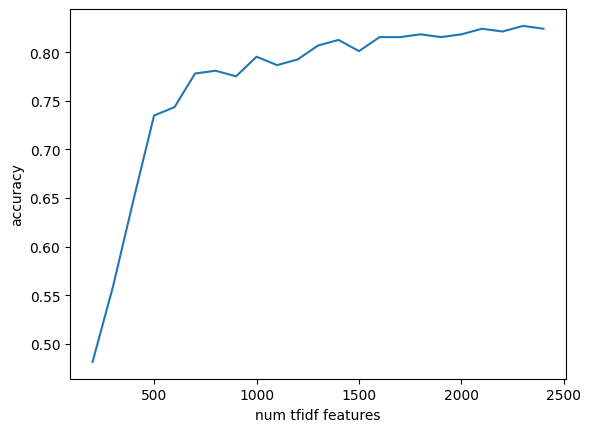

In [31]:
xs = list(range(200,2500,100))
plt.plot(xs,accs,'-')
plt.xlabel('num tfidf features')
plt.ylabel('accuracy')
plt.show()